# **Data Preparation**

## Library Import

In [11]:
# Imports
import numpy as np
import pandas as pd
import pickle
import os

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from scipy.spatial.distance import cdist
from collections import Counter
from concurrent.futures import ThreadPoolExecutor

## Dataset

In [12]:
# Dataset Paths
current_dir = os.path.dirname(os.path.abspath("__file__"))
train_path = os.path.join(current_dir, "../data/train.csv")
test_path = os.path.join(current_dir, "../data/test.csv")

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

## Data Preprocessing

In [13]:
def preprocess_data(train_df, test_df=None, test_size=0.3, random_state=42):
    X = train_df.drop(['label', 'id', 'FILENAME', 'URL', 'Domain'], axis=1)
    y = train_df['label']

    numeric_columns = X.select_dtypes(include=['number']).columns
    categorical_columns = X.select_dtypes(exclude=['number']).columns

    for col in numeric_columns:
        X[col] = np.log1p(X[col])

    for col in numeric_columns:
        X[col] = X[col].fillna(X[col].median())

    for col in categorical_columns:
        X[col] = X[col].fillna(X[col].mode()[0])

    scaler = StandardScaler()
    X[numeric_columns] = scaler.fit_transform(X[numeric_columns])

    label_encoders = {}
    for col in categorical_columns:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])
        label_encoders[col] = le

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=random_state
    )

    smote = SMOTE(random_state=random_state, k_neighbors=1)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    if test_df is not None:
        X_test_final = test_df.drop(['id', 'FILENAME', 'URL', 'Domain'], axis=1)
        for col in numeric_columns:
            X_test_final[col] = np.log1p(X_test_final[col])
            X_test_final[col] = X_test_final[col].fillna(X_test_final[col].median())
        for col in categorical_columns:
            X_test_final[col] = X_test_final[col].fillna(X_test_final[col].mode()[0])
            X_test_final[col] = X_test_final[col].map(lambda val: label_encoders[col].transform([val])[0]
                                                      if val in label_encoders[col].classes_
                                                      else -1)
        X_test_final[numeric_columns] = scaler.transform(X_test_final[numeric_columns])
    else:
        X_test_final = None

    return X_train_resampled, X_test, y_train_resampled, y_test, X_test_final

# KNN Algorithm

In [14]:


class KNNClassifier:
    def __init__(self, k=3, metric="euclidean", batch_size=1000, n_threads=4):
        """
        Initialize the KNN Classifier with thread pool support.

        Parameters:
        -----------
        k : int, default=3
            Number of neighbors to use
        metric : str, default="euclidean"
            Distance metric to use
        batch_size : int, default=1000
            Number of test points to process in each batch
        n_threads : int, default=4
            Number of threads to use for parallel processing
        """
        self.k = k
        self.metric = metric
        self.batch_size = batch_size
        self.n_threads = n_threads
        self.train_data = None
        self.train_labels = None

    def fit(self, train_data, train_labels):
        """
        Store the training data and labels.
        """
        self.train_data = np.asarray(train_data, dtype=np.float32)
        self.train_labels = np.asarray(train_labels)
        return self

    def _compute_batch_distances(self, test_batch):
        """
        Compute distances for a batch of test points.
        """
        if self.metric == 'euclidean':
            distances = cdist(test_batch, self.train_data, metric='euclidean')
        elif self.metric == 'manhattan':
            distances = cdist(test_batch, self.train_data, metric='cityblock')
        elif self.metric == 'minkowski':
            distances = cdist(test_batch, self.train_data, metric='minkowski')
        else:
            raise ValueError(f"Unsupported metric: {self.metric}")
        return distances

    def _predict_batch(self, test_batch):
        """
        Predict labels for a batch of test points.
        """
        distances = self._compute_batch_distances(test_batch)
        batch_predictions = []

        for point_distances in distances:
            k_indices = np.argpartition(point_distances, self.k)[:self.k]
            k_labels = self.train_labels[k_indices]

            prediction = Counter(k_labels).most_common(1)[0][0]
            batch_predictions.append(prediction)

        return batch_predictions

    def predict(self, test_points):
        """
        Predict labels for test points using a thread pool.
        """
        if self.train_data is None:
            raise ValueError("Model has not been trained. Call 'fit' first.")

        test_points = np.asarray(test_points, dtype=np.float32)
        predictions = []

        # Split test points into batches
        batches = [
            test_points[i:i + self.batch_size]
            for i in range(0, len(test_points), self.batch_size)
        ]

        # Use ThreadPoolExecutor for parallel processing
        with ThreadPoolExecutor(max_workers=self.n_threads) as executor:
            results = executor.map(self._predict_batch, batches)

        for result in results:
            predictions.extend(result)

        return np.array(predictions)

    def get_params(self, deep=True):
        return {
            'k': self.k,
            'metric': self.metric,
            'batch_size': self.batch_size,
            'n_threads': self.n_threads
        }

    def set_params(self, **params):
        if 'k' in params:
            self.k = params['k']
        if 'metric' in params:
            self.metric = params['metric']
        if 'batch_size' in params:
            self.batch_size = params['batch_size']
        if 'n_threads' in params:
            self.n_threads = params['n_threads']
        return self

    def score(self, X_test, y_test):
        predictions = self.predict(X_test)
        return np.mean(predictions == y_test)

    def save_model(self, filename):
        """
        Save the model to a file.
        """
        with open(filename, 'wb') as f:
            pickle.dump(self, f)
        print(f"Model saved to {filename}")

    @staticmethod
    def load_model(filename):
        """
        Load the model from a file.
        """
        with open(filename, 'rb') as f:
            model = pickle.load(f)
        print(f"Model loaded from {filename}")
        return model

In [17]:
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, f1_score, confusion_matrix, classification_report
import pickle

# Preprocess data
X_train, X_test, y_train, y_test,X_final = preprocess_data(train_df)

# Train the KNN model
knn = KNNClassifier(k=4, metric='manhattan')
knn.fit(X_train, y_train)

# Generate predictions
predictions = knn.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, predictions)
roc_auc = roc_auc_score(y_test, predictions, multi_class='ovr', average='macro')
recall = recall_score(y_test, predictions, average='macro')
precision = precision_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')

# Print metrics
print(f"Accuracy: {accuracy}")
print(f"ROC AUC Score: {roc_auc}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"F1 Score: {f1}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
class_report = classification_report(y_test, predictions)
print("Classification Report:")
print(class_report)

Accuracy: 0.9731019419780638
ROC AUC Score: 0.86067797986059
Recall: 0.8606779798605901
Precision: 0.9361982705532068
F1 Score: 0.8941758627892029
Confusion Matrix:
[[ 2306   860]
 [  273 38683]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.73      0.80      3166
           1       0.98      0.99      0.99     38956

    accuracy                           0.97     42122
   macro avg       0.94      0.86      0.89     42122
weighted avg       0.97      0.97      0.97     42122



In [19]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
import pandas as pd

# Preprocess data
X_train, X_test, y_train, y_test, _ = preprocess_data(train_df)

# Train the KNN model using sklearn
knn = KNeighborsClassifier(n_neighbors=4, metric='manhattan')
knn.fit(X_train, y_train)

# Generate predictions
predictions = knn.predict(X_test)

# Check if ROC AUC score is valid (requires probabilities for each class)
if len(knn.classes_) > 2:  # Multiclass case
    probabilities = knn.predict_proba(X_test)
    roc_auc = roc_auc_score(y_test, probabilities, multi_class='ovr', average='macro')
else:  # Binary case
    probabilities = knn.predict_proba(X_test)[:, 1]  # Select positive class probabilities
    roc_auc = roc_auc_score(y_test, probabilities)

# Calculate other evaluation metrics
accuracy = accuracy_score(y_test, predictions)
recall = recall_score(y_test, predictions, average='macro')
precision = precision_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')

# Print metrics
print(f"Accuracy: {accuracy}")
print(f"ROC AUC Score: {roc_auc}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"F1 Score: {f1}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
class_report = classification_report(y_test, predictions)
print("Classification Report:")
print(class_report)

Accuracy: 0.9705854422866911
ROC AUC Score: 0.8888659684214084
Recall: 0.8728111187787742
Precision: 0.9080282247111293
F1 Score: 0.8894615202110798
Confusion Matrix:
[[ 2399   767]
 [  472 38484]]
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.76      0.79      3166
           1       0.98      0.99      0.98     38956

    accuracy                           0.97     42122
   macro avg       0.91      0.87      0.89     42122
weighted avg       0.97      0.97      0.97     42122



In [8]:
import pandas as pd

# Preprocess the train and test data
X_train, X_test_split, y_train, y_test_split, X_test = preprocess_data(train_df, test_df)

# Train the KNN model
knn = KNNClassifier(k=4, metric='manhattan')
knn.fit(X_train, y_train)

# Predict using the KNN model
predictions = knn.predict(X_test)

# Save predictions in the required format
submission = pd.DataFrame({
    "id": test_df["id"],  # Use the 'id' column from the test data
    "label": predictions   # Add the predicted labels
})

# Specify the file path for saving
submission_file_path = 'submission.csv'
submission.to_csv(submission_file_path, index=False)

print(f"Predictions saved to '{submission_file_path}'.")

Predictions saved to 'submission.csv'.


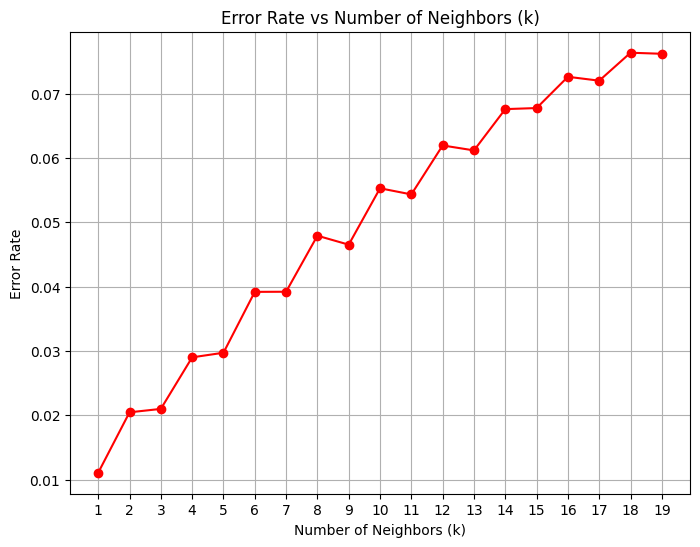

In [17]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Split data again to ensure consistency
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(
    X_train, y_train, test_size=0.3, random_state=42, stratify=y_train
)

# Range of k values
k_values = range(1, 20)

# List to store error rates
error_rates = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
    knn.fit(X_train_split, y_train_split)
    predictions = knn.predict(X_test_split)
    error_rate = 1 - accuracy_score(y_test_split, predictions)
    error_rates.append(error_rate)

# Plot the error rate graph
plt.figure(figsize=(8, 6))
plt.plot(k_values, error_rates, marker='o', linestyle='-', color='red')
plt.title('Error Rate vs Number of Neighbors (k)')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Error Rate')
plt.xticks(k_values)
plt.grid()
plt.show()
